In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats
from scipy.stats import multinomial
from scipy.stats import poisson
from scipy.stats import binom
from statistics import mean
import scipy.linalg as la

In [2]:
class Parameters:
    
    def __init__(self,N = 20000,t=50,r = 0.5,z = .1,u = 1e-9,G = 6.4e9, c = 10,dt = None):
        
        if not dt:
            dt_r = 0.09/r
            dt_u = 0.09/u
            dt_c = 0.09/c
            dt = min(min(dt_u,dt_c),min(dt_r,0.1))
            
        assert r*dt < 0.1
        assert u*dt < 0.1
        
        #if not t:
         #   t = c
            
        self.N = N
        self.t = t
        self.r = r
        self.z = z
        self.u = u
        self.G = G
        self.c = c
        self.dt = dt

In [42]:
#The simulation
def GSE(array, numElems):
    out = []
    for i in (np.linspace(0, len(array)-1, numElems)).astype(int):
        out.append(array[i])
    return out

def FuncCond(p): 
    p0Av = []
    p1Av = []
    p2Av = []
    p3Av = []
    
    G = np.zeros([p.N, 4, int(p.t/p.dt)],dtype = int)
    G[:,0,0] = p.G 
    time_past = 0

    
    for y in range(int(p.t/(p.c))):
        
        #this is a wierd time step thing where the first iteration we manually do the 0 step above. 
        if y == 0 :
            time = int(p.c/p.dt) - 1
        else :
            time = int(p.c/p.dt)
            
        for x in range(time):
            
            # do new lesions first.
            # how many new lesions
            new_lesions = poisson.rvs(G[:,0,x+time_past]*p.u*p.dt)
    
            # how old lesions are repaired, incorrectly and correctly
            repaired_lesions = binom.rvs(G[:,1,x+time_past],p.r*p.dt)
            incorrectly_repaired_lesions = binom.rvs(repaired_lesions,p.z)
            correctly_repaired_lesions = repaired_lesions - incorrectly_repaired_lesions
        
            G[:,3,x+1+time_past] = G[:,3,x+time_past] + new_lesions
            G[:,0,x+1+time_past] = G[:,0,x+time_past] - new_lesions + correctly_repaired_lesions
            G[:,1,x+1+time_past] = G[:,1,x+time_past] + new_lesions - repaired_lesions
            G[:,2,x+1+time_past] = G[:,2,x+time_past] + incorrectly_repaired_lesions
            
            if x == time-1:
                delete_list = np.where(G[:,1,((y+1)*int(p.c/p.dt))-1]>0)[0]
                alive_list = np.where(G[:,1,((y+1)*int(p.c/p.dt))-1]==0)[0]
                print(p.N - len(delete_list))
                if p.N - len(delete_list)<50:
                    print("less than 50 survived at cell cycle")    
                replacements = np.random.choice([i for i in range(p.N) if i not in delete_list],len(delete_list))
                G[delete_list,:,:] = G[replacements,:,:]
        
        time_past += time
    
    p0Av = list(np.mean(G[:,0,:],axis=0))
    p1Av = list(np.mean(G[:,1,:],axis=0))
    p2Av = list(np.mean(G[:,2,:],axis=0))
    p3Av = list(np.mean(G[:,3,:],axis=0))
   # p3err = list(stats.sem((G[alive_list,3,:]),axis=0))

    return [GSE(p0Av,p.t+1),GSE(p1Av,p.t+1),GSE(p2Av,p.t+1),GSE(p3Av,p.t+1),p3Av[-1]] #,p3err[-1]]

In [45]:
def Func_les_cond(p):
    L = p.c*p.u*p.G
    r = p.c*p.r
    e = math.e
    a = 1-((1/(r))*(1-e**(-r)))  
    les = a*L 
    return les 

def Func_mut(p):
    Func_les_cond(p)*p.z
    

def AnaP2(p):
    r = p.c*p.r
    e = math.e
    a = (1-((1/(r))*(1-e**(-r))))  
    return (p.t*p.u*p.z*p.G)*a
    
def Function_lesions(p):
    return p.t*p.u*p.G*p.z 

In [46]:
r_values = [.01,.1,1]
u_values = [2e-11,2e-10,2e-11]
i = 0
j = 0
A = []
C = []

for i in range(1,50):
    p = Parameters(t = i, r = .1, u = 2e-10,)
    C.append(Function_lesions(p))
    A.append(AnaP2(p))


In [47]:
r_vals = [.01,.1,1]
u_vals = [2e-11,2e-10,2e-11]
i = 0
j = 0
D = []

p = Parameters(t = 50, r = .1, u = 2e-10,)
B = FuncCond(p)[2]

'''
for u in u_values:
    j=0
    for r in r_values:
        p = Parameters(r = r, u = u)
        D.append(FuncCond(p)[2])
        j = j+1
    i = i+1
'''

5348
5310
5250
5327
5340


'\nfor u in u_values:\n    j=0\n    for r in r_values:\n        p = Parameters(r = r, u = u)\n        D.append(FuncCond(p)[2])\n        j = j+1\n    i = i+1\n'

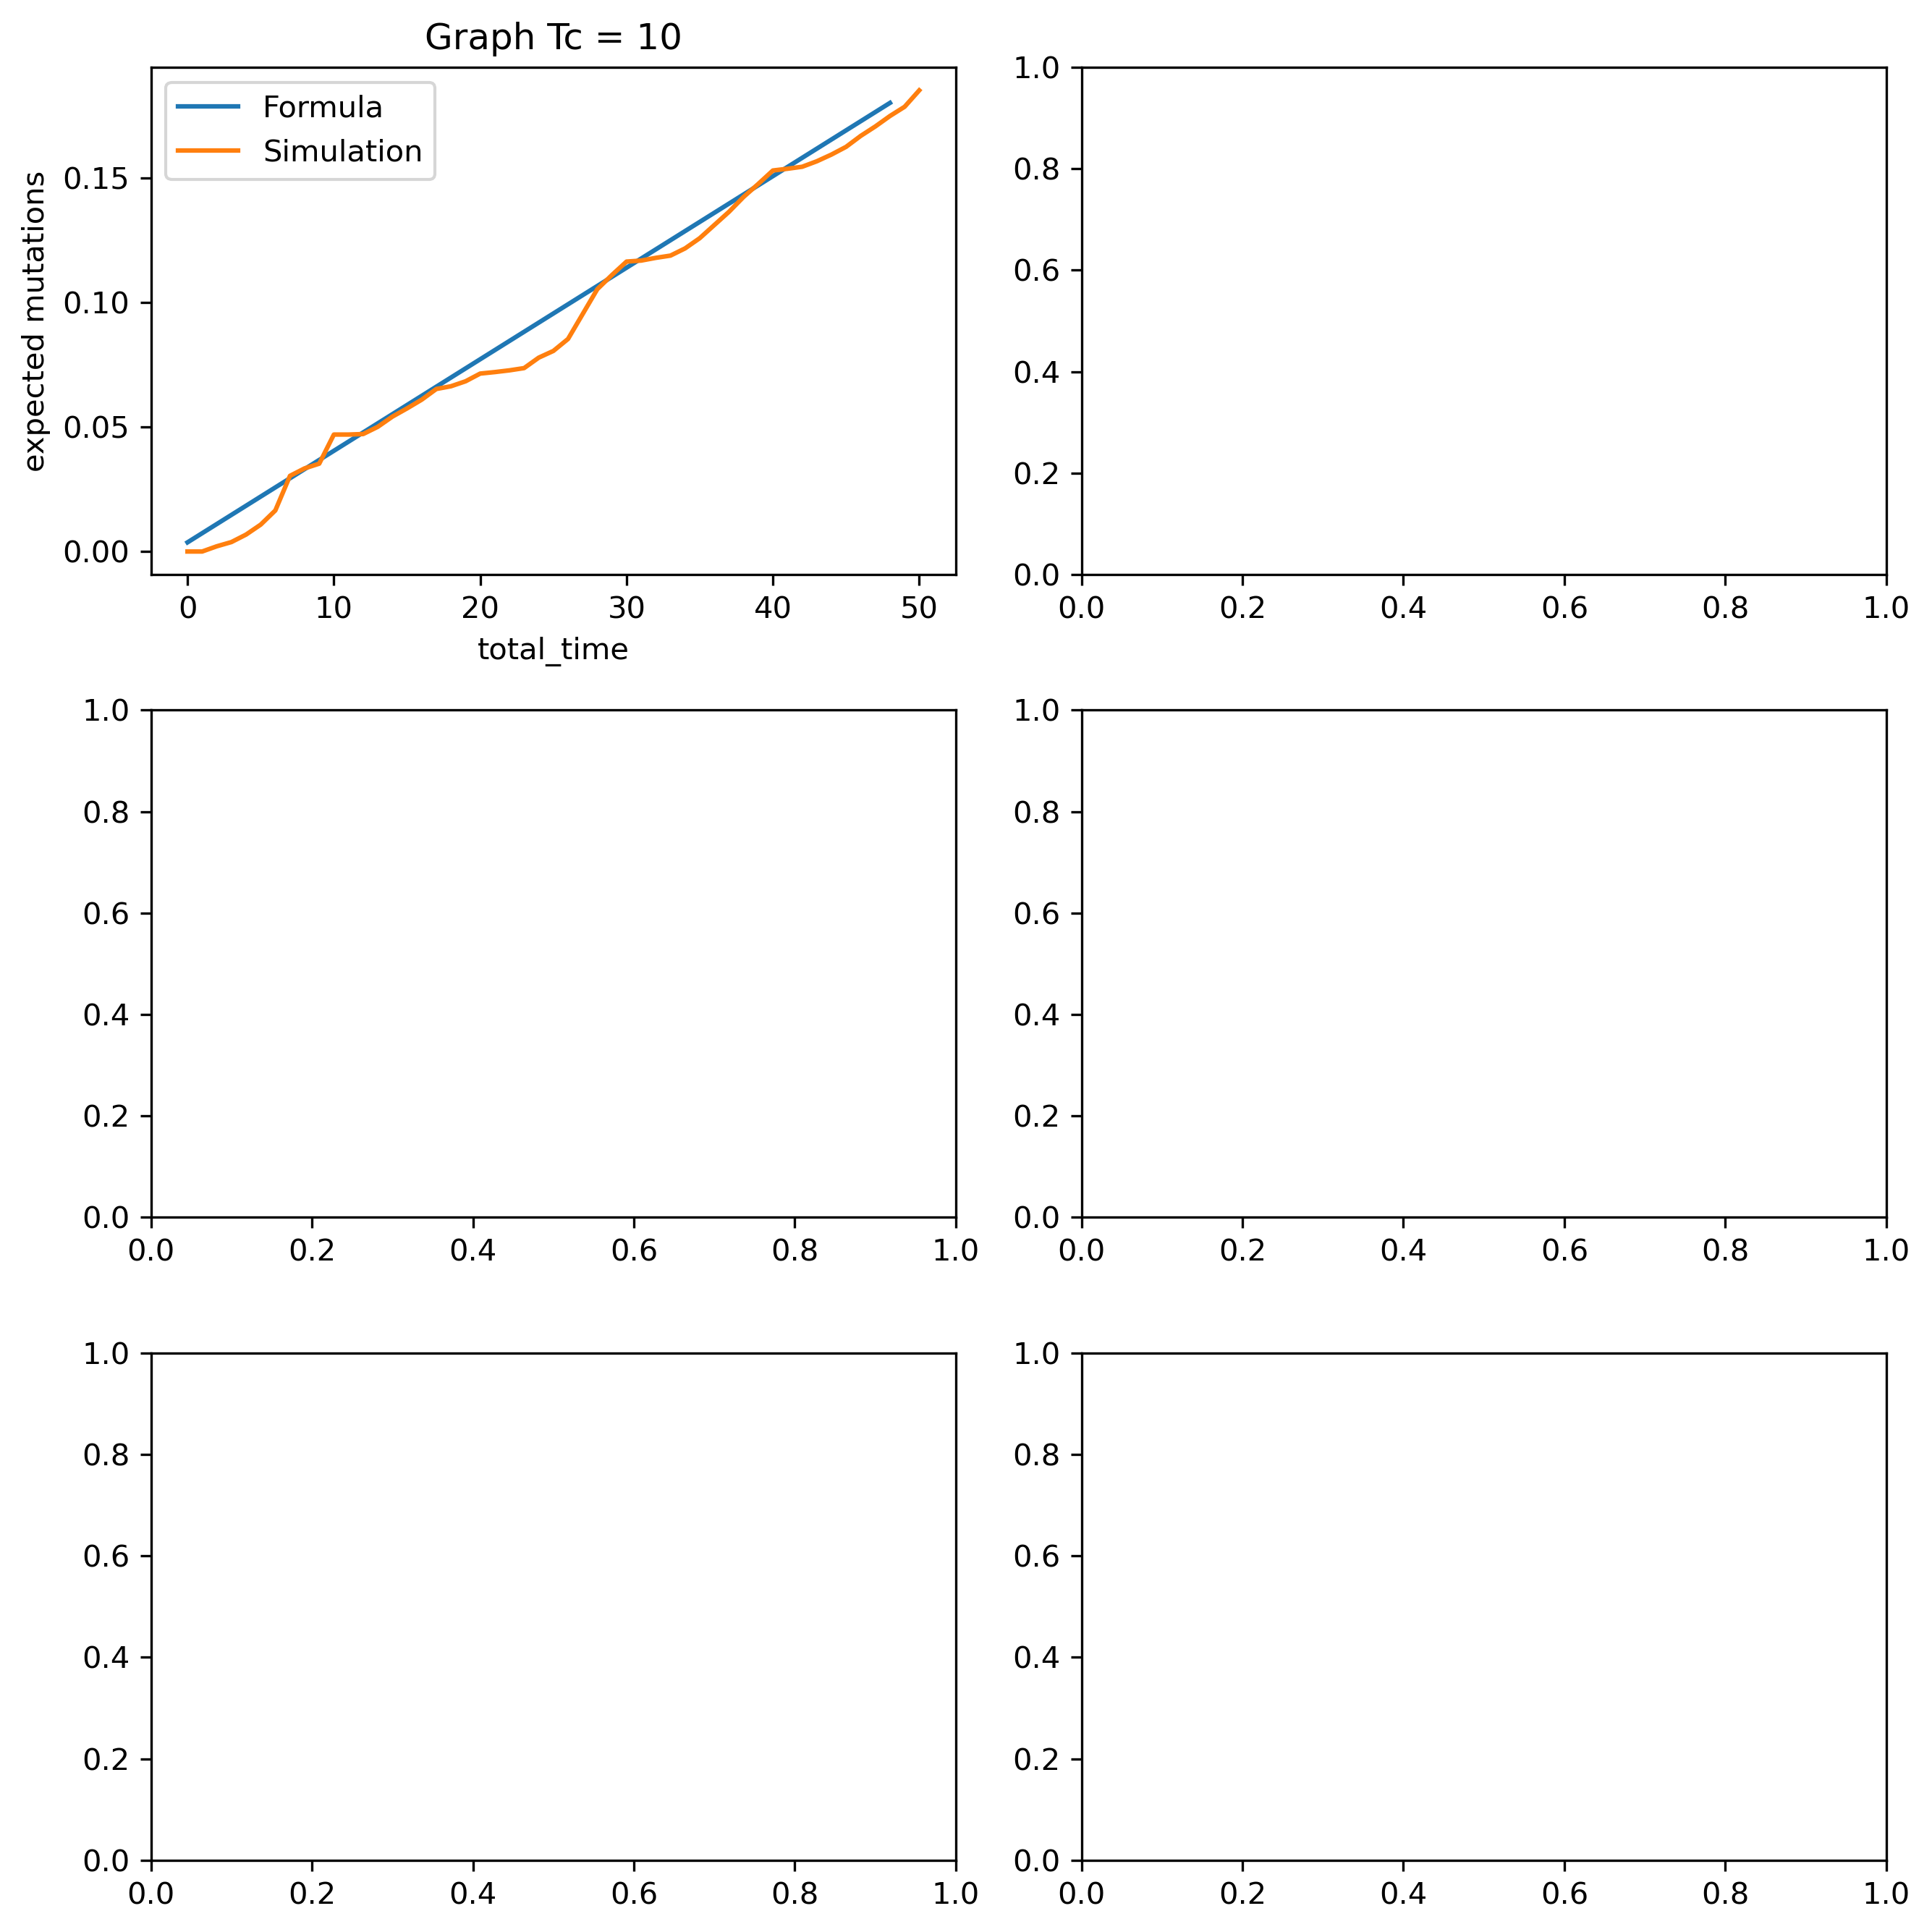

In [48]:
eigen_color,eigen_ls = 'tab:orange','--'
sim_color, sim_ls = 'tab:blue','-'
lit_color,lit_ls = 'tab:green',':'

n_rows = 3
figure, axis = plt.subplots(n_rows, 2, dpi = 300, figsize = (9,3*n_rows))

axis[0,0].plot(A)
axis[0,0].plot(B)
axis[0,0].set_xlabel("total_time")
axis[0,0].set_ylabel("expected mutations")
axis[0,0].set_title("Graph Tc = 10")
axis[0,0].legend(["Formula", "Simulation"])




plt.tight_layout()
plt.show()